In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(1/3/np.pi)
r2 = np.sqrt((1/3/np.pi+r1**2))
r1, r2

(0.32573500793527993, 0.46065886596178063)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of

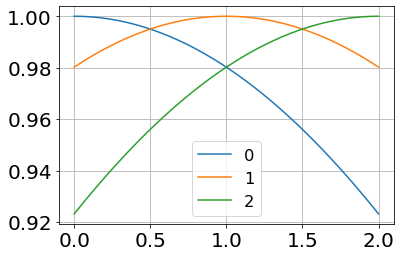

In [10]:
xx = np.linspace(0,2,num = 100000)
p0 = np.exp(-xx**2/(2*5**2))
p1 = np.exp(-(xx-1)**2/(2*5**2))
p2 = np.exp(-(xx-2)**2/(2*5**2))

fig, ax  = plt.subplots(1,1)
ax.plot(xx, p0)
ax.plot(xx, p1)
ax.plot(xx, p2)
ax.legend(['0','1','2'])
ax.grid(visible = True)
fig.show()


In [11]:
%%time
path_figs = './figs/2Mstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 0 ns, sys: 846 µs, total: 846 µs
Wall time: 3.67 ms


In [12]:
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.325735]
r_big = [0.325735,0.46065886]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000


In [13]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609


In [14]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.000020e+00,5.001005e-01,8.330335e-01,8.404234e-01,1.003147e+00
std,2.887267e-01,2.886267e-01,8.164207e-01,5.000001e-01,5.045290e+00,5.047374e+00,7.113687e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-2.559529e+01,-2.292883e+01,-3.242735e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-2.568211e+00,-2.569452e+00,-3.791629e+00
50%,4.999703e-01,5.003810e-01,1.000000e+00,1.000000e+00,8.355991e-01,8.383376e-01,9.974728e-01
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,4.233814e+00,4.248720e+00,5.803340e+00
max,9.999993e-01,9.999997e-01,2.000000e+00,1.000000e+00,2.612381e+01,2.604293e+01,3.584543e+01


In [15]:
data['C'].value_counts()/len(data)

1    0.333458
2    0.333281
0    0.333261
Name: C, dtype: float64

In [16]:
data.groupby('C').ITE.mean()

C
0    0.004805
1    1.000390
2    2.004189
Name: ITE, dtype: float64

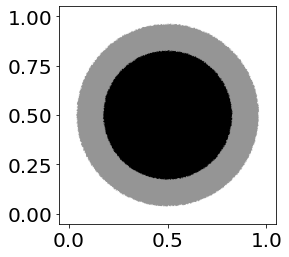

In [50]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [18]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [19]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 1h 11min 35s, sys: 4.45 s, total: 1h 11min 40s
Wall time: 1h 11min 41s


In [20]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,1,2.129169,-4.529616
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,0,1.373003,0.567504
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765,1,2.026313,-10.738816
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159,0,-0.206649,-8.049329
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609,0,1.530793,-7.659106


### Model performance

In [21]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.981341  1.008926  0.993484  0.027585  0.012143
            1        1.044385  1.036434  0.987491 -0.007950 -0.056894
          1 0        0.004829  1.008538  1.028823  1.003709  1.023994
            1        0.006390  1.007373  1.028903  1.000982  1.022512
          2 0       -0.007826  2.000617  1.981560  2.008443  1.989386
            1       -0.001260  2.026991  1.983800  2.028251  1.985060
1         0 0        0.989184  0.997210  0.943759 -0.008025  0.045426
            1        1.010891  1.033520  0.943119 -0.022630  0.067772
          1 0        1.003812  0.003512  0.044573  1.000300  0.959239
            1        0.994443  0.007608  0.040794  0.986834  0.953649
          2 0        2.010384  0.001865 -0.011194  2.008519  2.021577
            1        1.988376  0.042260 -0.013048  1.946116  2.001424

### Apply clustering Box and Kmeans

In [22]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 20h 42min 25s, sys: 1h 33min 18s, total: 22h 15min 43s
Wall time: 1h 49min 34s


In [23]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,1,2.129169,-4.529616,982,675
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,0,1.373003,0.567504,762,203
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765,1,2.026313,-10.738816,866,271
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159,0,-0.206649,-8.049329,1200,1166
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609,0,1.530793,-7.659106,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [24]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [25]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.134381,1409.0,1.0,0.000705
1,1,0.062804,1451.0,1.0,0.000726
2,2,-0.101859,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


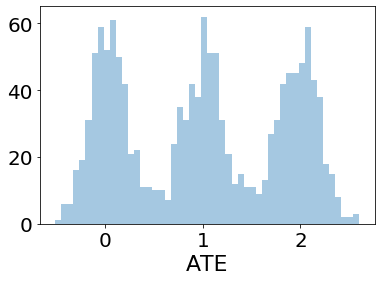

In [60]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 50
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


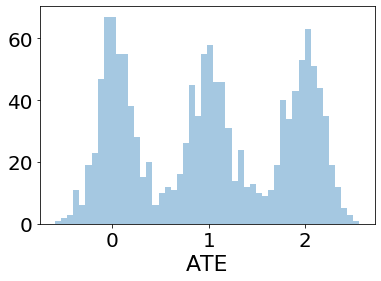

In [61]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'],
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


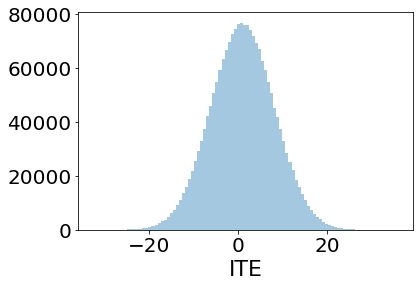

In [62]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 100,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [29]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.003310,1460.920380,0.961037,0.000730
std,395.34057,0.822437,37.097551,0.116090,0.000019
min,0.00000,-0.515984,1345.000000,0.500666,0.000673
25%,342.00000,0.154030,1435.000000,1.000000,0.000718
50%,684.00000,1.012108,1460.000000,1.000000,0.000730
75%,1026.00000,1.827585,1486.000000,1.000000,0.000743
max,1368.00000,2.604595,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [30]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


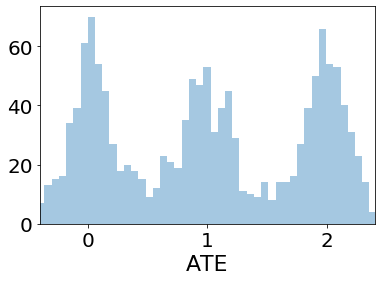

In [77]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.4,2.4)

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


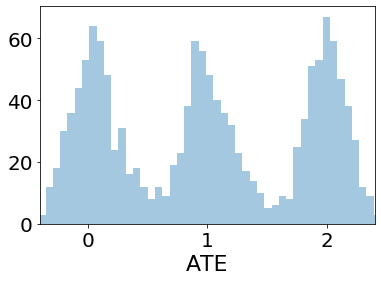

In [76]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.4,2.4)

if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


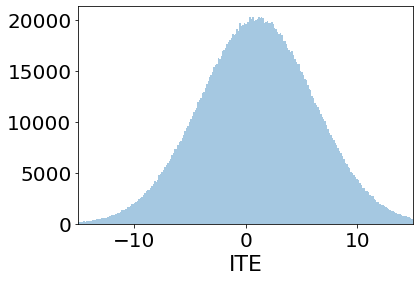

In [78]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = 400, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [34]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 3
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N )
    


Did not pick 3, it picked: 0
Did not pick 3, it picked: 0
CPU times: user 1.05 s, sys: 40 ms, total: 1.09 s
Wall time: 1.17 s


In [35]:
box['Box-Cl2'].value_counts()

0    462
2    456
1    451
Name: Box-Cl2, dtype: int64

In [36]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.134381,1409.0,1.0,0.000705,0
1,1,0.062804,1451.0,1.0,0.000726,0


In [37]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,1,2.129169,-4.529616,982,675
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,0,1.373003,0.567504,762,203


### 3 Clustering in the ITEs

In [38]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5

data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2

#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [39]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [40]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,1,2.129169,-4.529616,982,675,0,0,2,2,2,2
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,0,1.373003,0.567504,762,203,2,1,2,2,2,2


### Plot reconstruction of data

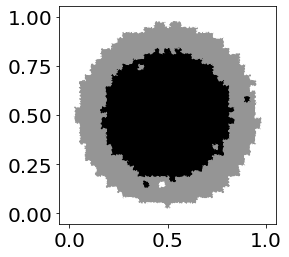

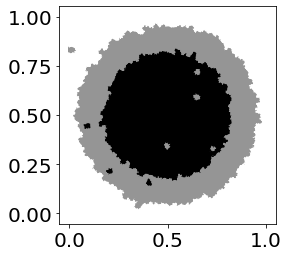

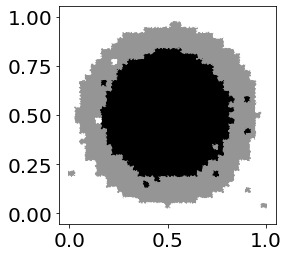

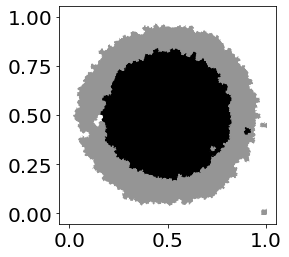

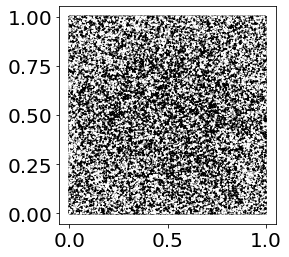

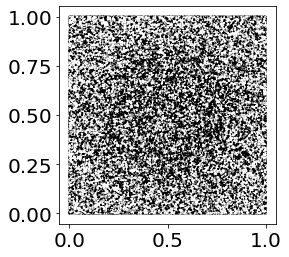

CPU times: user 9min 43s, sys: 13.3 s, total: 9min 56s
Wall time: 9min 41s


In [59]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [42]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [43]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [44]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [45]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [46]:
errors.sort_values(by = 'mean')

,mean,std
Kmeans-Cl2-err-True-ITE,0.059141,0.200627
Kmeans-Cl2-err-GDBR,0.062767,0.199577
Kmeans2-Cl2-err-GDBR,0.064929,0.198396
Box-Cl2-err-True-ITE,0.065532,0.205164
Kmeans2-Cl2-err-True-ITE,0.068085,0.197253
Box-Cl2-err-GDBR,0.068988,0.204087
Box2-Cl2-err-True-ITE,0.078381,0.214181
Box2-Cl2-err-GDBR,0.078439,0.214410
ITE-2CTrue-err-GDBR,2.830202,0.955754
ITE-2CGDBR-err-True-ITE,3.918685,1.229577


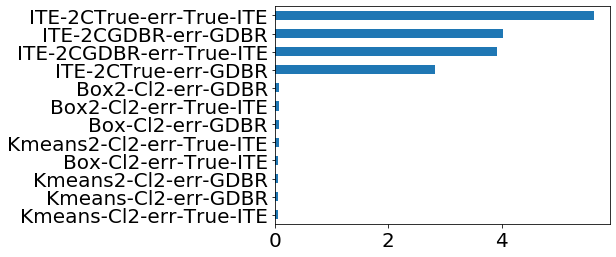

In [47]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [48]:
from evaluations import confusion_matrix
    

In [49]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 3, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.967411,0.032589,0.000000
C1 True,0.045307,0.923161,0.031532
C2 True,0.000000,0.032465,0.967535


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.96891,0.031090,0.000000
C1 True,0.03971,0.932771,0.027519
C2 True,0.00000,0.034931,0.965069


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.962253,0.037747,0.000000
C1 True,0.052545,0.902869,0.044586
C2 True,0.000000,0.025710,0.974290


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.974049,0.025951,0.000000
C1 True,0.057096,0.920788,0.022117
C2 True,0.000000,0.028910,0.971090


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.528022,0.055764,0.416214
C1 True,0.472453,0.056530,0.471017
C2 True,0.415897,0.055657,0.528446


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.537878,0.076474,0.385648
C1 True,0.461399,0.078581,0.460020
C2 True,0.382132,0.078096,0.539771


In [70]:
data2.groupby('ITE-2CGDBR').std()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.299984,0.299983,0.808188,0.500000,4.826466,5.037963,5.844077,0.400581,1.017944,3.009741,410.622221,395.221727,0.813063,0.810341,0.808150,0.815211,0.812021,0.204209,0.200000,0.215215,0.199501,0.951052,0.808188,0.205650,0.201337,0.215315,0.198593,1.431114,0.808188
1,0.287998,0.287877,0.814120,0.500001,1.042582,5.025624,5.042087,0.398259,1.018838,0.288907,394.167429,394.950715,0.959699,0.816460,0.814205,0.820871,0.819060,0.204010,0.198219,0.214890,0.197239,1.016758,0.472344,0.205055,0.199216,0.214658,0.196073,1.640410,0.468089
2,0.277175,0.276971,0.809607,0.500000,5.631132,5.060388,5.851364,0.399711,1.108591,3.002072,379.246461,394.574446,0.814084,0.812791,0.810680,0.816648,0.815809,0.203954,0.199356,0.213501,0.197430,0.949801,0.809607,0.204689,0.200143,0.212955,0.196075,1.428860,0.809607


In [68]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.499602,0.500057,0.887296,0.499527,0.828378,0.842930,-3.306744,0.200776,0.827216,-3.414637,684.069700,681.223109,0.466290,0.884566,0.883924,0.889438,0.875507,0.071223,0.065121,0.080561,0.068249,2.827927,4.301934,0.066818,0.060696,0.079688,0.070678,5.628110,4.194040
1,0.500364,0.500667,1.006974,0.500640,0.830775,0.845145,0.989897,0.197690,0.829621,1.000836,684.909879,683.122842,0.996655,1.001956,1.001325,1.008042,0.993965,0.068705,0.061906,0.078490,0.064159,2.844317,0.663112,0.065322,0.058353,0.078443,0.067366,5.569880,0.666313
2,0.499867,0.500262,1.111244,0.500581,0.838056,0.837130,5.302710,0.199615,0.830777,5.414677,684.351973,681.644325,1.532220,1.104951,1.103981,1.111868,1.097795,0.066808,0.060565,0.076315,0.061748,2.830094,4.303433,0.064286,0.057723,0.077068,0.065620,5.628686,4.191466


In [69]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(4.039255836336277, 3.057149546478276)